In [195]:
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython import display
from sklearn import datasets, preprocessing
import tensorflow as tf

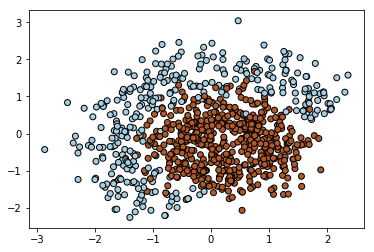

In [276]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > X[:,0] - 0.5)
X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], cmap=plt.cm.Paired, c=y, edgecolors='black')

plt.show()

In [277]:
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, loss, n_iter):
    plt.clf()
    plt.figure(figsize=(20, 8))
    Z = classify(np.c_[xx.ravel(), yy.ravel()], w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())


**Your task starts here**

First, let's write a function that predicts class for given X.

Since the problem above isn't linearly separable, we add quadratic features to the classifier. This transformation is implemented in the __expand__ function.

__Don't forget to expand X inside classify and other functions__

Sample classification should not be much harder than computation of sign of dot product.

In [278]:
def expand(X):
    X0 = tf.transpose(tf.gather(tf.transpose(X), [0]))
    X1 = tf.transpose(tf.gather(tf.transpose(X), [1]))
    X_ = tf.concat([X, X ** 2, X0 * X1, tf.ones_like(X0)], axis=1)
    return X_

def classify(X, w):
    """
    Given feature matrix X [n_samples,2] and weight vector w [6],
    return an array of +1 or -1 predictions
    """
    expand_X = expand(X)
    row_predictions = tf.reduce_sum(expand_X * w, axis=1)
    
    ones = tf.ones(X.shape[0])
    zeros = tf.zeros(X.shape[0])
    
    return tf.where(row_predictions > 0.5, ones, zeros)

The loss you should try to minimize is the Hinge Loss:

$$ L =  {1 \over N} \sum_{i=1}^N max(0,1-y_i \cdot  w^T x_i) $$



In [351]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    expand_X = expand(X)
    row_predictions = tf.matmul(tf.expand_dims(w, 0), tf.transpose(expand_X))
    y_row_predictions = y*row_predictions
    max_array = tf.maximum(1 - y_row_predictions, 0)
    return 1.0/tf.to_float(tf.shape(X)[0]) * tf.reduce_sum(max_array)
    
def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    expand_X = expand(X)
    
    row_predictions = tf.squeeze(tf.matmul(tf.expand_dims(w, 0), tf.transpose(expand_X)))
    y_row_predictions = y*row_predictions
    max_array = tf.maximum(1 - y_row_predictions, 0)
    
    derative = tf.transpose(-1.0/tf.to_float(tf.shape(X)[0]) * y * tf.transpose(expand_X))
    each_grad = tf.where(tf.equal(max_array, 0), tf.zeros_like(derative), derative)
    return tf.reduce_sum(each_grad, axis=0)

In [352]:
XX = tf.constant([[1, 1], [2, 1], [0, 0], [1, 1]], dtype=tf.float32)
yy = tf.constant([1, -1, 1, 1], dtype=tf.float32)
ww = tf.constant([0.5, 0.1, -0.3, 0.1, 0.2, 0.6])
cp = compute_grad(XX, yy, ww)

with tf.Session() as sess:
    res = sess.run(cp)
    print(res)

[ 0.5   0.25  1.    0.25  0.5   0.  ]


### Training
Find an optimal learning rate for gradient descent for given batch size. 

You can see the example of correct output below this cell before you run it.

**Don't change the batch size!**

In [440]:
alpha = 0.05 # learning rate

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

w_tf = tf.Variable([1,0,0,0,0,0], dtype=tf.float32)
X_tf = tf.placeholder(dtype=tf.float32, name="X")
y_tf = tf.placeholder(dtype=tf.float32, name="Y")

loss_tf = compute_loss(X_tf, y_tf, w_tf)
loss_grad = compute_grad(X_tf, y_tf, w_tf)
update_weights = w_tf.assign(w_tf - alpha*loss_grad)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
#        visualize(X[ind,:], y[ind], w, loss, n_iter)
        sess.run(update_weights, {X_tf: X[ind, :], y_tf: y[ind]})
        loss[i], w = sess.run([loss_tf, w_tf], {X_tf: X, y_tf: y})
        print(loss[i])

#         visualize(X, y, w, loss, n_iter)
#         plt.clf()

0.792119324207
0.764964580536
0.753893733025
0.741407871246
0.725448429585
0.708626329899
0.694484293461
0.676110327244
0.653303444386
0.646430373192
0.637242436409
0.627911031246
0.615711510181
0.621792435646
0.613365888596
0.604473233223
0.588901638985
0.583148658276
0.565949678421
0.555189371109
0.550028264523
0.541556119919
0.535313487053
0.524687767029
0.494273453951
0.46451985836
0.460041433573
0.448010414839
0.444160968065
0.43881419301
0.431183606386
0.41970911622
0.414896428585
0.404822647572
0.404822647572
0.406378269196
0.40103250742
0.399104475975
0.398917704821
0.400515258312
0.39699536562
0.39699536562
0.395496606827
0.392782747746
0.398422300816
0.401656538248
0.399830460548
0.404380589724
0.405304193497
0.422368854284
0.407541424036
0.392157256603
0.37955224514
0.381359636784
0.375537872314
0.367682188749
0.358779042959
0.353835940361
0.356443583965
0.353059917688
0.357734084129
0.348359674215
0.339377433062
0.336048543453
0.333316028118
0.333316028118
0.330945312977
0.

Implement gradient descent with momentum and test it's performance for different learning rate and momentum values.

In [385]:
alpha = 0.05 # learning rate
mu    = 0.9 # momentum

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

w_tf = tf.Variable([1,0,0,0,0,0], dtype=tf.float32)
momentum_tf = tf.Variable([0, 0, 0, 0, 0, 0], dtype=tf.float32)
X_tf = tf.placeholder(dtype=tf.float32, name="X")
y_tf = tf.placeholder(dtype=tf.float32, name="Y")

loss_tf = compute_loss(X_tf, y_tf, w_tf)
loss_grad = compute_grad(X_tf, y_tf, w_tf)
update_weights = w_tf.assign(w_tf + momentum_tf)
update_momentum = momentum_tf.assign(momentum_tf*mu - alpha*loss_grad)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        _, _ = sess.run([update_momentum, update_weights], {X_tf: X[ind, :], y_tf: y[ind]})
        loss[i], w = sess.run([loss_tf, w_tf], {X_tf: X, y_tf: y})
#        visualize(X[ind,:], y[ind], w, loss, n_iter)
        print(loss[i])
    
# visualize(X, y, w, loss, n_iter)
# plt.clf()

0.791663825512
0.778896391392
0.766261160374
0.74269002676
0.70394796133
0.653651475906
0.610448896885
0.560525298119
0.51708060503
0.475659966469
0.431644558907
0.390211373568
0.358326137066
0.34124442935
0.322421878576
0.302391797304
0.288682937622
0.278375178576
0.267543435097
0.260595142841
0.259547531605
0.249817013741
0.24249124527
0.233137890697
0.226023748517
0.219855815172
0.215596184134
0.214904025197
0.215919673443
0.214475259185
0.213785856962
0.208889365196
0.204770341516
0.20129878819
0.196623310447
0.194728299975
0.19350668788
0.191664367914
0.191066607833
0.191339865327
0.191959321499
0.193598791957
0.197005316615
0.195985421538
0.192568838596
0.194084599614
0.196984440088
0.200829461217
0.205074667931
0.209848940372
0.214139193296
0.218732446432
0.225979492068
0.228750869632
0.223113596439
0.216990217566
0.20964191854
0.204250857234
0.205288752913
0.207657128572
0.212201505899
0.210830196738
0.2100777179
0.206436559558
0.205475226045
0.205357819796
0.20755982399
0.2105

Same task but for Nesterov's accelerated gradient:

In [404]:
alpha = 0.05 # learning rate
mu    = 0.9 # momentum

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

w_tf = tf.Variable([1,0,0,0,0,0], dtype=tf.float32)
momentum_tf = tf.Variable([0, 0, 0, 0, 0, 0], dtype=tf.float32)
X_tf = tf.placeholder(dtype=tf.float32, name="X")
y_tf = tf.placeholder(dtype=tf.float32, name="Y")

loss_tf = compute_loss(X_tf, y_tf, w_tf)
loss_grad = compute_grad(X_tf, y_tf, w_tf)
update_weights_momentum = w_tf.assign(w_tf + momentum_tf)
update_weights_gradient = w_tf.assign(w_tf - alpha*loss_grad)
update_momentum = momentum_tf.assign(momentum_tf*mu - alpha*loss_grad)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        sess.run([update_momentum, update_weights_momentum, update_weights_gradient], {X_tf: X[ind, :], y_tf: y[ind]})
        loss[i], w = sess.run([loss_tf, w_tf], {X_tf: X, y_tf: y})
#        visualize(X[ind,:], y[ind], w, loss, n_iter)
        print(loss[i])
# visualize(X, y, w, loss, n_iter)
# plt.clf()

0.776662409306
0.746613442898
0.698480844498
0.646033644676
0.608408749104
0.593567430973
0.603828310966
0.60837751627
0.601215302944
0.584041833878
0.585202097893
0.53966909647
0.481019973755
0.40678280592
0.354035079479
0.299781113863
0.242612242699
0.22374111414
0.22661742568
0.240752667189
0.262198537588
0.284411489964
0.307311594486
0.316499948502
0.312161952257
0.301095694304
0.287530899048
0.271713942289
0.25083386898
0.238894790411
0.227163657546
0.21404401958
0.203260436654
0.191396683455
0.184272661805
0.17729459703
0.171447664499
0.167860686779
0.166589051485
0.166884049773
0.168350338936
0.173075184226
0.179497435689
0.186855688691
0.191684365273
0.196692630649
0.194675698876
0.18857049942
0.183551803231
0.182848840952
0.185724109411
0.18894700706
0.18841765821
0.187807753682
0.190846562386
0.200187668204
0.214729145169
0.231112509966
0.247496590018
0.256308197975
0.264268964529
0.256365597248
0.242288857698
0.238649174571
0.237479060888
0.233787387609
0.226254224777
0.2227

Same task but for AdaGrad:

In [450]:
alpha = 0.3 # learning rate
mu    = 0 # momentum
eps = 1e-8  # A small constant for numerical stability

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

w_tf = tf.Variable([1,0,0,0,0,0], dtype=tf.float32)
cw_tf = tf.Variable([1, 1, 1, 1, 1, 1], dtype=tf.float32)
momentum_tf = tf.Variable([0, 0, 0, 0, 0, 0], dtype=tf.float32)
X_tf = tf.placeholder(dtype=tf.float32, name="X")
y_tf = tf.placeholder(dtype=tf.float32, name="Y")

loss_tf = compute_loss(X_tf, y_tf, w_tf)
loss_grad = compute_grad(X_tf, y_tf, w_tf)
coef_tf = tf.div(alpha, (tf.sqrt(cw_tf) + eps))
update_weights = w_tf.assign(w_tf - coef_tf * loss_grad)
update_cw = cw_tf.assign(cw_tf + loss_grad*loss_grad)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        sess.run([update_weights, update_cw], {X_tf: X[ind, :], y_tf: y[ind]})
        loss[i], w = sess.run([loss_tf, w_tf], {X_tf: X, y_tf: y})
        print(loss[i])

# visualize(X, y, w, loss, n_iter)
# plt.clf()

0.76444631815
0.744959115982
0.706931293011
0.611712753773
0.609875559807
0.543388426304
0.534794032574
0.609917759895
0.537812650204
0.476418584585
0.415344834328
0.406553208828
0.379674464464
0.33916926384
0.323463499546
0.316953867674
0.300307542086
0.273025393486
0.254749983549
0.259173154831
0.275310367346
0.263585805893
0.252719074488
0.257778376341
0.248202517629
0.242893382907
0.255285650492
0.255285650492
0.238195374608
0.235996797681
0.234031587839
0.231650903821
0.243363291025
0.243363291025
0.233819320798
0.219627663493
0.216816395521
0.216816395521
0.213658705354
0.213781744242
0.218498751521
0.218498751521
0.218498751521
0.215493991971
0.219756901264
0.214125454426
0.214125454426
0.222724750638
0.222724750638
0.223176270723
0.21329241991
0.227430358529
0.222165152431
0.210035860538
0.197654768825
0.198784485459
0.197728261352
0.196345418692
0.198568925261
0.198568925261
0.203690364957
0.206133261323
0.206133261323
0.202321857214
0.202321857214
0.202321857214
0.20232185721

Same task but for AdaDelta:

In [465]:
alpha = 0.3 # learning rate
beta = 0.99
gamma    = 0.7 # coeff
eps = 1e-8  # A small constant for numerical stability

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

w_tf = tf.Variable([1,0,0,0,0,0], dtype=tf.float32)
cw_tf = tf.Variable([1, 1, 1, 1, 1, 1], dtype=tf.float32)
momentum_tf = tf.Variable([0, 0, 0, 0, 0, 0], dtype=tf.float32)
X_tf = tf.placeholder(dtype=tf.float32, name="X")
y_tf = tf.placeholder(dtype=tf.float32, name="Y")

loss_tf = compute_loss(X_tf, y_tf, w_tf)
loss_grad = compute_grad(X_tf, y_tf, w_tf)
coef_tf = tf.div(alpha, (tf.sqrt(cw_tf) + eps))
update_weights = w_tf.assign(w_tf - coef_tf * loss_grad)
update_cw = cw_tf.assign(cw_tf + loss_grad*loss_grad)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        sess.run([update_weights, update_cw], {X_tf: X[ind, :], y_tf: y[ind]})
        loss[i], w = sess.run([loss_tf, w_tf], {X_tf: X, y_tf: y})
        print(loss[i])

0.736647546291
0.638391196728
0.602192878723
0.589314639568
0.558982789516
0.55379986763
0.481844604015
0.466990947723
0.421863675117
0.410996764898
0.367324322462
0.364126116037
0.323152244091
0.323152244091
0.344783574343
0.344509214163
0.33967000246
0.298499643803
0.287345796824
0.287345796824
0.281652331352
0.291949272156
0.274069726467
0.268653780222
0.267067044973
0.257124960423
0.252981722355
0.248018473387
0.242426946759
0.231443956494
0.228926315904
0.225366979837
0.224690929055
0.243085965514
0.24330329895
0.24330329895
0.245756879449
0.221003115177
0.221682175994
0.221682175994
0.21931900084
0.217871367931
0.224431306124
0.234044194221
0.234044194221
0.225181162357
0.220633581281
0.214638352394
0.218752264977
0.210217371583
0.208203420043
0.206434190273
0.204531565309
0.204291641712
0.21221485734
0.21221485734
0.223807707429
0.211177185178
0.211620762944
0.202326253057
0.210197344422
0.207337617874
0.200329229236
0.200329229236
0.198222279549
0.199147209525
0.198891982436
0.

Same task for Adam algorithm. You can start with beta = 0.9 and mu = 0.999

In [384]:
alpha = 0.05 # learning rate
beta = 0.9  # (beta1 coefficient in original paper) exponential decay rate for the 1st moment estimates
mu   = 0.999  # (beta2 coefficient in original paper) exponential decay rate for the 2nd moment estimates
eps = 1e-8  # A small constant for numerical stability

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

w_tf = tf.Variable([1,0,0,0,0,0], dtype=tf.float32)
cw_tf = tf.Variable([0, 0, 0, 0, 0, 0], dtype=tf.float32)
momentum_tf = tf.Variable([0, 0, 0, 0, 0, 0], dtype=tf.float32)
X_tf = tf.placeholder(dtype=tf.float32, name="X")
y_tf = tf.placeholder(dtype=tf.float32, name="Y")

loss_tf = compute_loss(X_tf, y_tf, w_tf)
loss_grad = compute_grad(X_tf, y_tf, w_tf)
update_momentum = momentum_tf.assign(beta*momentum_tf + (1 - beta)*loss_grad)
update_weights = w_tf.assign(w_tf - alpha/(tf.sqrt(cw_tf) + eps) * momentum_tf)
update_cw = cw_tf.assign(cw_tf*mu + (1 - mu)*loss_grad*loss_grad)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        sess.run([update_cw, update_momentum, update_weights], {X_tf: X[ind, :], y_tf: y[ind]})
        loss[i], w = sess.run([loss_tf, w_tf], {X_tf: X, y_tf: y})
        print(loss[i])

0.791663825512
0.744778931141
0.813827514648
0.77558273077
0.624506354332
0.57499140501
0.455645799637
0.339671880007
0.268160432577
0.257063955069
0.257405102253
0.25424259901
0.238252848387
0.220183566213
0.209735840559
0.200793474913
0.194462493062
0.19082814455
0.186528563499
0.18376134336
0.181645840406
0.180298998952
0.189703002572
0.200702100992
0.212319761515
0.22381696105
0.234901875257
0.245758220553
0.239049956203
0.233653411269
0.229287996888
0.225779488683
0.231292307377
0.231489866972
0.23175753653
0.225890353322
0.224702551961
0.223675265908
0.20500279963
0.193468227983
0.194830626249
0.188260689378
0.182489022613
0.181288659573
0.18162317574
0.182934448123
0.183461174369
0.184684187174
0.187363579869
0.192389324307
0.198784783483
0.200188934803
0.197566270828
0.19624632597
0.196081489325
0.19631113112
0.198483079672
0.198251694441
0.198379188776
0.193694874644
0.189245313406
0.188572600484
0.186671152711
0.188189938664
0.191460609436
0.19645357132
0.202530875802
0.20583